In [1]:
from symreg import Regressor
import pandas as pd
import numpy as np
import random
import traceback
import time
import re

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from multiprocessing import Pool


In [ ]:
diff_data, duration_per = 1200, 5 # 30 minutes -> 4.55 minutes (7 jobs))
n_jobs = 7
# diff_data, duration_per   = 30, 3 # instant

X, y = load_boston(return_X_y=True)
X /= X.mean()
y /= y.mean()
X, Xt, y, yt = train_test_split(X, y, test_size=0.4, random_state=0)

results = []

parallel_speedup = 1/(1+(n_jobs-1)*.88)

def time_left(diff_data):
    return f'{parallel_speedup * diff_data * duration_per / 60:.2} minutes'

print(f'Will take {time_left(diff_data)}')

def eval_settings(**settings):
    r = Regressor(duration=duration_per, **settings)
    r.fit(X, y)
    
    y_out = r.predict(Xt, max_complexity=10)
    error = np.median((yt - y_out) ** 2)
    return {**settings, **{'error': error}}

def process(i):
    random.seed(i)
    muts = {    
        'prune_mutation_chance':     random.random(),
        'hoist_mutation_chance':     random.random(),
        'grow_leaf_mutation_chance': random.random(),
        'grow_root_mutation_chance': random.random(),
    }
    point_mut_chance = random.random()
    
    fix_muts = {
    }
    
    totalmut = point_mut_chance + sum(v for v in muts.values())
    totalfixmut = sum(v for v in fix_muts.values())
    
    muts = {k: v*(1-totalfixmut)/totalmut for k, v in muts.items()}
        
    try:
        args = {
            **muts,
            **fix_muts,
            'simplify_chance': random.random(),
            'n': random.choice([20, 30, 50, 80, 130]),
            'mutation_children': random.choice([1, 2, 3, 5]),
            'crossover_children': random.choice([1, 2, 3, 5]),
        }

        my_result = eval_settings(**args)
        print(my_result)
        print('============', time_left(diff_data - i-1), 'left')
        return my_result
    except ValueError as e:
        print('============', 'Value Error for seed', i, ': ', args)
        traceback.print_exc()
    except AssertionError as e:
        print('============', 'AssertionError for seed', i, ': ', args)
        traceback.print_exc()

start = time.time()
with Pool(7) as p:
    results = [res for res in p.map(process, range(diff_data)) if res is not None]
print("actually taken (min):", (time.time()-start)/60)


In [3]:
pd.DataFrame(results).sort_values('error').to_csv('metaopt.tsv', sep='\t', index=False)

In [4]:
resdf = pd.read_csv('metaopt.tsv', sep='\t').sort_values('error').dropna()
resdf['point_chance'] = 1-resdf[['hoist_mutation_chance', 'prune_mutation_chance', 'grow_root_mutation_chance', 'grow_leaf_mutation_chance']].sum(axis=1)

split = list(map(int, np.linspace(0, 100, 31)[1:]))
percs = [s/100 for s in split]
names = [f'{s}%' for s in split]
percentiles = resdf['error'].describe(percentiles=percs).loc[names]
resdf['chunk'] = 0
for p in percentiles:
    resdf.loc[resdf['error'] > p, 'chunk'] += 1

final_res = pd.concat([resdf.groupby('chunk').mean(), resdf.groupby('chunk').count()['error']], axis=1)


# Best and worst chunk errors (linspace 31 items): 
"""
0.012147
0.012760
0.013755

0.028538
0.029985
0.039792
"""

final_res

,prune_mutation_chance,hoist_mutation_chance,grow_leaf_mutation_chance,grow_root_mutation_chance,simplify_chance,n,mutation_children,crossover_children,error,point_chance,error
chunk,,,,,,,,,,,
0,0.197504,0.227528,0.171451,0.202605,0.477341,64.054054,2.432432,2.945946,0.011750,0.200911,37
1,0.214568,0.213244,0.178302,0.196285,0.424471,73.714286,2.371429,2.457143,0.012947,0.197601,35
2,0.190016,0.198703,0.187962,0.181449,0.568900,58.750000,3.000000,2.895833,0.013876,0.241871,48
3,0.190788,0.182344,0.207224,0.217177,0.562899,76.388889,2.111111,3.194444,0.014627,0.202466,36
4,0.224810,0.183737,0.203018,0.184018,0.454151,65.833333,2.750000,3.250000,0.015251,0.204418,36
5,0.189434,0.186561,0.185740,0.220348,0.490990,60.208333,2.750000,2.604167,0.015842,0.217918,48
6,0.206036,0.180933,0.207026,0.192208,0.486622,66.666667,2.666667,2.750000,0.016435,0.213796,36
7,0.200180,0.177656,0.216512,0.223011,0.519036,63.333333,2.694444,2.888889,0.016837,0.182641,36
8,0.184934,0.211452,0.191476,0.204140,0.460844,52.083333,2.958333,3.041667,0.017328,0.207998,48


We chose production parameters from the top row of above: 0.24 for hoist_mutation_chance and grow_root_mutation_chance, and 0.16 for prune_mutation_chance and grow_leaf_mutation_chance, and 0.5 for simplify_chance.

<AxesSubplot:xlabel='error'>

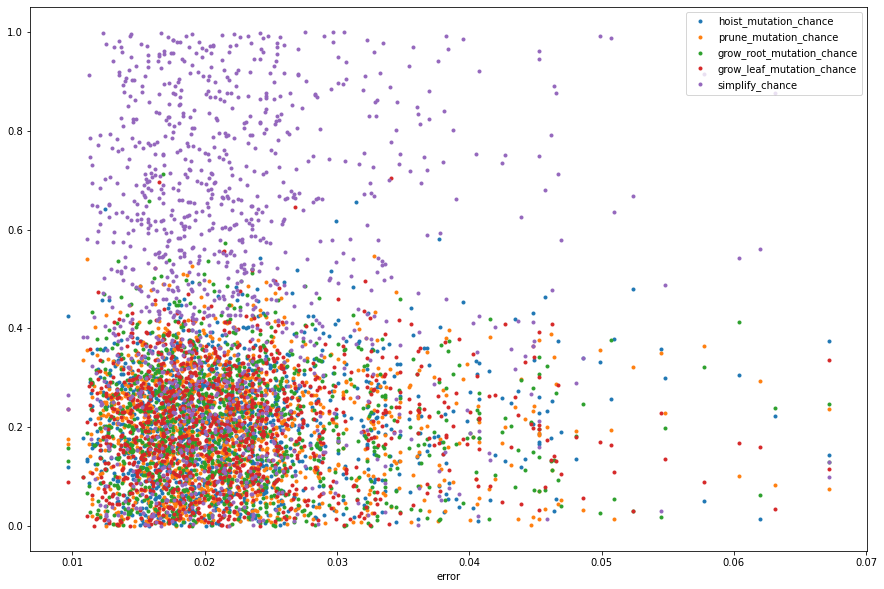

In [5]:
resdf.plot(y = ['hoist_mutation_chance', 'prune_mutation_chance', 'grow_root_mutation_chance', 'grow_leaf_mutation_chance', 'simplify_chance'], x='error', style='.', figsize=(15, 10))

In [6]:
resdf.corr('spearman')['error']

prune_mutation_chance       -0.030234
hoist_mutation_chance        0.046282
grow_leaf_mutation_chance    0.038555
grow_root_mutation_chance   -0.038363
simplify_chance              0.024601
n                            0.017298
mutation_children           -0.019565
crossover_children          -0.031668
error                        1.000000
point_chance                -0.037812
chunk                        0.999410
Name: error, dtype: float64

<AxesSubplot:xlabel='chunk'>

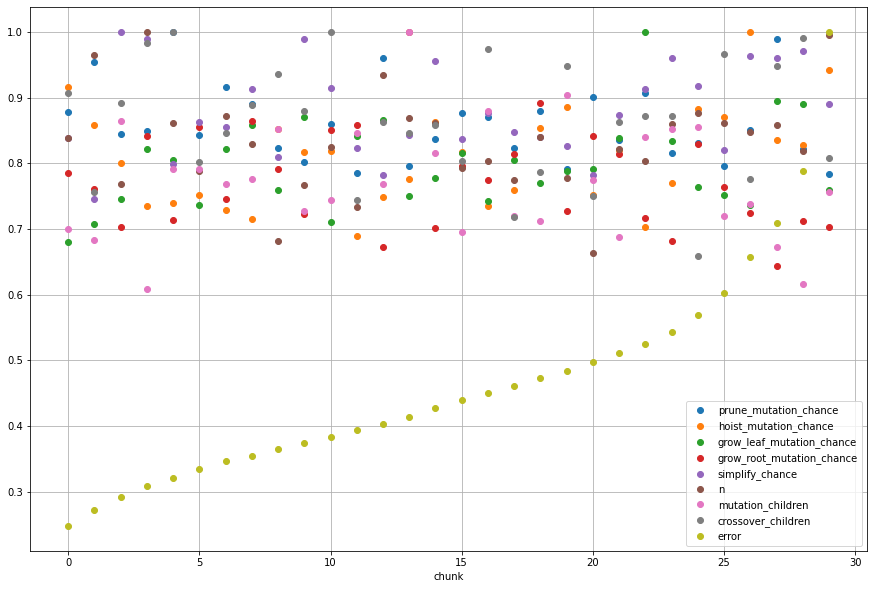

In [7]:
noerror = final_res.iloc[:, :-2]
noerror /= noerror.max()
noerror.plot(figsize=(15, 10), grid=True, style='o')

We train another Regressor, to explain the error of the previous one. But there's still work to do for interpretability of the results.

In [8]:
r2 = Regressor(duration=10, verbose=True, simplify_chance=.01)
X2 = resdf.loc[:,  [c for c in resdf.columns if c not in ['error', 'chunk']]]
y2 = resdf.loc[:, 'error']
X2['rand'] = np.random.random(np.shape(X2.iloc[:, 0]))  # Add decoys as witnesses of overfitting
X2['rand2'] = np.random.random(np.shape(X2.iloc[:, 0]))
X2 /= X2.mean()
y2 /= y2.mean()
X2

,prune_mutation_chance,hoist_mutation_chance,grow_leaf_mutation_chance,grow_root_mutation_chance,simplify_chance,n,mutation_children,crossover_children,point_chance,rand,rand2
0,0.859892,2.113816,0.445883,0.663835,0.473412,0.789162,1.858160,1.789442,0.910097,0.229742,0.556658
1,0.911414,0.596902,1.184533,0.785454,0.530947,0.789162,1.858160,1.789442,1.506199,0.160323,0.295673
2,1.740448,0.889968,0.498205,0.499185,0.761770,1.262659,1.114896,0.357888,1.390822,0.888174,0.311595
3,1.848834,0.677772,1.047862,0.334512,0.762151,2.051822,1.858160,1.789442,1.120355,0.309003,0.396319
4,2.805427,0.660223,0.105554,0.939131,1.160009,1.262659,0.371632,0.715777,0.571726,1.645676,1.355891
...,...,...,...,...,...,...,...,...,...,...,...
1195,0.522615,1.516537,0.835052,2.066728,1.081546,1.262659,1.858160,1.789442,0.064752,0.473181,0.432551
1196,1.519937,0.068320,0.798987,0.313911,1.117630,2.051822,0.371632,1.789442,2.288257,0.715252,1.527637
1197,0.427421,1.108257,0.176781,1.194024,1.748077,2.051822,0.743264,0.715777,2.046137,0.891672,1.203810
1198,1.227208,0.713669,0.575916,1.230136,0.200363,2.051822,1.114896,1.073665,1.257082,0.988098,1.724794


<AxesSubplot:>

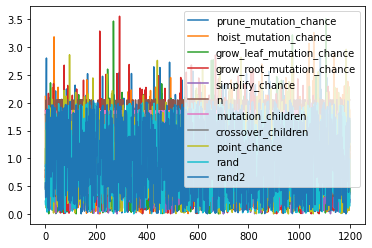

In [9]:
X2.plot()

In [10]:
r2.fit(X2, y2)

Time left  : 8.97s
Best so far: (0.35621596337939126, 13) (error, complexity)
Time left  : 7.95s
Best so far: (0.35547486209910173, 20) (error, complexity)
Time left  : 6.92s
Best so far: (0.3547926822294409, 35) (error, complexity)
Time left  : 5.91s
Best so far: (0.3533212730612121, 58) (error, complexity)
Time left  : 4.90s
Best so far: (0.35323151496604127, 32) (error, complexity)
Time left  : 3.87s
Best so far: (0.3529097875119579, 36) (error, complexity)
Time left  : 2.86s
Best so far: (0.35271734668815286, 36) (error, complexity)
Time left  : 1.82s
Best so far: (0.3526730589822635, 70) (error, complexity)
Time left  : 0.80s
Best so far: (0.3524268619190549, 68) (error, complexity)
Complete. {'generations': 341, 'stagnated_generations': 0, 'duration': 10.066643476486206}


In [11]:
"""
[{'error': 0.3376952051100154, 'complexity': 1, 'program': Program('1.0', 12)},
"""

r2.results()[:10]

[{'error': 0.35724838391734814,
  'complexity': 1,
  'program': Program('1.0', 11)},
 {'error': 0.3570011480559763,
  'complexity': 3,
  'program': Program('pow 1.011586283217278 $hoist_mutation_chance', 11)},
 {'error': 0.35646741201321347,
  'complexity': 5,
  'program': Program('pow pow 1.011586283217278 $hoist_mutation_chance $hoist_mutation_chance', 11)},
 {'error': 0.3559972614441798,
  'complexity': 7,
  'program': Program('pow pow pow 1.011586283217278 $hoist_mutation_chance $hoist_mutation_chance $n', 11)},
 {'error': 0.35541403113689124,
  'complexity': 9,
  'program': Program('pow pow pow 1.011586283217278 sub $hoist_mutation_chance $grow_root_mutation_chance $hoist_mutation_chance $hoist_mutation_chance', 11)},
 {'error': 0.3547086574202184,
  'complexity': 11,
  'program': Program('pow pow pow pow 1.011586283217278 sub $hoist_mutation_chance $grow_root_mutation_chance $hoist_mutation_chance $n 2.3426914223023876', 11)},
 {'error': 0.35404287516282806,
  'complexity': 13,
 

<AxesSubplot:xlabel='$0'>

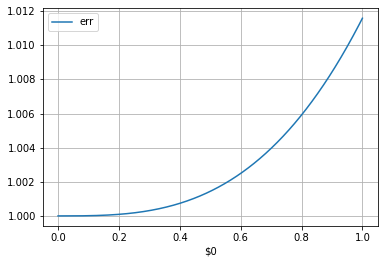

In [16]:
X3 = pd.DataFrame({'$0': np.linspace(0, 1, 1001)})
from symreg.ga import Program
p = Program(
   re.sub('\$[a-z_]+', '$0',
          'pow pow pow 1.011586283217278 sub .5 $grow_root_mutation_chance  $hoist_mutation_chance'
         )
)
X3['err'] = p.eval([X3['$0']])
X3.plot(x='$0', y='err', grid=True)

In [13]:
resdf.loc[:,  [c for c in resdf.columns if c not in ['error', 'chunk']]]

,prune_mutation_chance,hoist_mutation_chance,grow_leaf_mutation_chance,grow_root_mutation_chance,simplify_chance,n,mutation_children,crossover_children,point_chance
0,0.165732,0.424971,0.089471,0.132822,0.237305,50,5,5,0.187005
1,0.175662,0.120004,0.237688,0.157156,0.266145,50,5,5,0.309491
2,0.335446,0.178923,0.099970,0.099878,0.381849,80,3,1,0.285783
3,0.356336,0.136262,0.210264,0.066930,0.382040,130,5,5,0.230208
4,0.540705,0.132734,0.021180,0.187904,0.581472,80,1,2,0.117477
...,...,...,...,...,...,...,...,...,...
1195,0.100726,0.304891,0.167562,0.413516,0.542142,80,5,5,0.013305
1196,0.292945,0.013735,0.160325,0.062808,0.560230,130,1,5,0.470186
1197,0.082379,0.222809,0.035473,0.238903,0.876251,130,2,2,0.420436
1198,0.236526,0.143479,0.115563,0.246129,0.100435,130,3,3,0.258303


In [14]:
Program('pow rec 0.9742252905025462 $n').simplify()

Program('pow 1.026456621223781 $n', 0)